### Jump to: <a id="contents"></a>

**Getting started**
- [import packages](#import)
- [import data](#data)

**Data acquisition**
- [find articles by field](#articles)
- [find hyperlinks](#hyperlinks)

**Hyperlink network**
- [build hyperlink network](#link_network)
- [calculate network features](#features)
- [degree distribution](#degree)
- [predict network attributes with field dummies](#ols)

**Cross-field network**
- [describe fields](#fields)
- [describe broad fields](#broad_desc)
- [depth *n* cross-field networks](#depth)

-------------------------

### import packages <a id="import">

[**back**](#contents)

In [1]:
import wikipediaapi

import numpy as np
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.interpolate import make_interp_spline as spline

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

import pickle
from tqdm.notebook import tqdm as tqdm
from itertools import combinations, repeat, chain, permutations, product

from functions import *

In [2]:
sns.set()

In [3]:
matplotlib.rcParams["figure.figsize"] = (15, 15)

-------------------------

### import data <a id="data">

[**back**](#contents)

In [4]:
glob.glob("output/*")

['output/articles.parquet',
 'output/field_dummies.parquet',
 'output/fields.parquet',
 'output/edges.parquet',
 'output/nodes.parquet',
 'output/depth_2_field_edges.parquet',
 'output/gls_coeff_matrix.parquet',
 'output/depth_2_field_link_matrix.parquet',
 'output/ols_coeff_matrix.parquet',
 'output/depth_3_field_edges.parquet',
 'output/depth_1_field_link_matrix.parquet',
 'output/depth_3_field_link_matrix.parquet']

In [5]:
articles = get("articles")

In [6]:
nodes = get("nodes")

In [7]:
edges = get("edges")

In [8]:
fields = get("fields")

In [9]:
L_link = build_graph(
    nodes["node"].unique(), edges[["from", "to"]].drop_duplicates().values, False, True
)

Name: 
Type: DiGraph
Number of nodes: 24638
Number of edges: 655873
Average in degree:  26.6204
Average out degree:  26.6204


In [174]:
nx.diameter(L_link)

14

In [10]:
field_dummies = get("field_dummies")

In [11]:
field_link_matrix = get("depth_1_field_link_matrix")

In [12]:
secondary_field_link_matrix = get("depth_2_field_link_matrix")

In [13]:
tertiary_field_link_matrix = get("depth_3_field_link_matrix")

------------

### find articles by field <a id="articles"></a>

[**back**](#contents)

**DATA SOURCE**:

last time of data acquisition: March 12, 2021

[**Wikipedia hyperlinks**](https://snap.stanford.edu/data/wiki-topcats.html)

[**Wikipedia-API documentation**](https://pypi.org/project/Wikipedia-API/)

**ACADEMIC FIELDS**:

based on [**Wikipedia's list of academic field**](https://en.wikipedia.org/wiki/List_of_academic_fields)

In [22]:
fields = pd.concat(
    [
        pd.DataFrame(
            [
                [n.split("\n")[0], n.split("\n")[k]]
                for k in range(1, len(n.split("\n")))
            ],
            columns=["broad_field", "field"],
        )
        for n in open("fields.txt", "r").read().split("\n\n")
    ]
).reset_index(drop=True)

In [23]:
class_dict = {
    **{"Archaeology": "Anthropology"},
    **{
        f: "Arts"
        for f in ["Culinary arts", "Literature", "Performing arts", "Visual arts"]
    },
    **{
        f: "Interdisciplinary studies"
        for f in [
            "Area studies",
            "Ethnic studies",
            "Cultural studies",
            "Gender studies",
            "Organizational studies",
        ]
    },
    **{"Astronomy": "Space science"},
    **{f: "Mathematics" for f in ["Applied mathematics", "Statistics"]},
}

In [24]:
wiki = wikipediaapi.Wikipedia(
    language="en", extract_format=wikipediaapi.ExtractFormat.WIKI
)

In [ ]:
articles_dict = {
    category: find_category_members(wiki, category)
    for category in tqdm(fields["field"].unique())
}

In [ ]:
articles = fields.merge(
    pd.concat(
        [
            pd.DataFrame([[key, v] for v in values], columns=["field", "article"])
            for key, values in articles_dict.items()
        ]
    ),
    on="field",
).assign(
    field=lambda df: df["field"].apply(
        lambda f: class_dict[f] if f in class_dict.keys() else f
    )
)

In [14]:
articles.head()

,broad_field,field,article
0,Humanities and social science,Anthropology,Ethnobiology
1,Humanities and social science,Anthropology,Complex society
2,Humanities and social science,Anthropology,Interindividual differences in perception
3,Humanities and social science,Anthropology,Téach
4,Humanities and social science,Anthropology,Political anthropology


In [ ]:
articles.to_parquet("output/articles.parquet", index=False)

------------

### find hyperlinks <a id="hyperlinks"></a>

[**back**](#contents)

In [ ]:
edges_dict = {}

for n in tqdm(articles["article"].unique()):

    edges_dict[n] = set(articles["article"]).intersection(find_links(wiki, n))

In [ ]:
all_edges = pd.DataFrame(
    np.concatenate(
        [
            np.array([[key, v] for v in values])
            for key, values in edges_dict.items()
            if len(values) != 0
        ]
    ),
    columns=["from", "to"],
).loc[lambda df: df["from"] != df["to"]]

In [ ]:
all_edges.to_parquet("output/all_edges.parquet", index=False)

--------------

### build hyperlink network <a id="link_network"></a>

[**back**](#contents)

In [ ]:
G_link = build_graph(articles["article"].unique(), all_edges.values, False, True)

In [ ]:
L_link = G_link.subgraph(max(nx.strongly_connected_components(G_link), key=len))

In [15]:
print(nx.info(L_link))

Name: 
Type: DiGraph
Number of nodes: 24638
Number of edges: 655873
Average in degree:  26.6204
Average out degree:  26.6204


In [ ]:
edges = (
    pd.DataFrame(list(L_link.edges()), columns=["from", "to"])
    .merge(
        articles.drop("broad_field", axis=1).rename(
            columns={"field": "field_from", "article": "from"}
        ),
        on="from",
        how="left",
    )
    .merge(
        articles.drop("broad_field", axis=1).rename(
            columns={"field": "field_to", "article": "to"}
        ),
        on="to",
        how="left",
    )
    .pipe(
        lambda df: df.merge(
            df.groupby(["from", "to"])["field_from"]
            .count()
            .pipe(lambda s: 1 / s)
            .reset_index()
            .rename(columns={"field_from": "weight"}),
            on=["from", "to"],
            how="left",
        )
    )
    .assign(within_field=lambda df: df["field_from"] == df["field_to"])
    .sort_values(by=["from", "to"])
    .reset_index(drop=True)
)

In [16]:
edges.head(5)

,from,to,field_from,field_to,weight,within_field
0,"""Holy...""",Catchphrase,Anthropology,Linguistics,0.5,False
1,"""Holy...""",Catchphrase,Interdisciplinary studies,Linguistics,0.5,False
2,'Ala' al-Din al-Bukhari,Akmal al-Din al-Babarti,Logic,Linguistics,1.0,False
3,'Ala' al-Din al-Bukhari,Astronomy in the medieval Islamic world,Logic,Space science,1.0,False
4,'Ala' al-Din al-Bukhari,Common Era,Logic,History,0.5,False


In [ ]:
edges.to_parquet("output/edges.parquet", index=False)

-------------------

### calculate network features <a id="features"></a>

[**back**](#contents)

In [ ]:
nodes = (
    articles.drop("broad_field", axis=1)
    .loc[articles["article"].isin(set(L_link.nodes()))]
    .reset_index(drop=True)
    .rename(columns={"article": "node"})
    .pipe(
        lambda df: df.merge(
            df[["node"]]
            .drop_duplicates()
            .pipe(
                lambda df2: df2.assign(
                    in_degree=df2["node"].apply(lambda n: L_link.in_degree(n)),
                    out_degree=df2["node"].apply(lambda n: L_link.out_degree(n)),
                    neighbor_conn=df2["node"].apply(
                        directed_neighbor_connectivity, args=(L_link, "both")
                    ),
                    in_neighbor_conn=df2["node"].apply(
                        directed_neighbor_connectivity, args=(L_link, "in")
                    ),
                    out_neighbor_conn=df2["node"].apply(
                        directed_neighbor_connectivity, args=(L_link, "out")
                    ),
                    clustering=df2["node"].apply(clustering, graph=L_link),
                    canopy=df2["node"].apply(lambda n: len(grow_canopy(n, L_link))),
                ),
            ),
            on="node",
        )
        .merge(
            pd.DataFrame.from_dict(
                nx.betweenness_centrality(L_link),
                orient="index",
                columns=["betweenness"],
            )
            .merge(
                pd.DataFrame.from_dict(
                    nx.closeness_centrality(L_link),
                    orient="index",
                    columns=["closeness_in"],
                ),
                left_index=True,
                right_index=True,
            )
            .merge(
                pd.DataFrame.from_dict(
                    nx.closeness_centrality(L_link.reverse()),
                    orient="index",
                    columns=["closeness_out"],
                ),
                left_index=True,
                right_index=True,
            )
            .reset_index()
            .rename(columns={"index": "node"}),
            on="node",
            how="left",
        )
        .merge(
            df.merge(
                edges.loc[edges["within_field"]],
                left_on=["node", "field"],
                right_on=["to", "field_to"],
            )
            .drop(["to", "field_from", "field_to"], axis=1)
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "within_field_in_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["from", "field_from"])
            .drop(["from", "field_from", "field_to"], axis=1)
            .loc[lambda df: df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "within_field_out_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["to", "field_to"])
            .drop(["to", "field_from", "field_to"], axis=1)
            .loc[lambda df: ~df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "cross_field_in_degree"}),
            on=["node", "field"],
            how="left",
        )
        .merge(
            df.merge(edges, left_on=["node", "field"], right_on=["from", "field_from"])
            .drop(["from", "field_from", "field_to"], axis=1)
            .loc[lambda df: ~df["within_field"]]
            .groupby(["node", "field"])["weight"]
            .sum()
            .reset_index()
            .rename(columns={"weight": "cross_field_out_degree"}),
            on=["node", "field"],
            how="left",
        )
        .fillna(0)
    )
)

In [31]:
nodes.head(5)

,field,node,in_degree,out_degree,neighbor_conn,in_neighbor_conn,out_neighbor_conn,clustering,canopy,betweenness,closeness_in,closeness_out,within_field_in_degree,within_field_out_degree,cross_field_in_degree,cross_field_out_degree
0,Anthropology,Ethnobiology,98,143,237.460581,97.969388,107.286713,0.296779,15350,0.000609,0.306946,0.299629,22.475000,24.891667,26.525000,46.608333
1,Biology,Ethnobiology,98,143,237.460581,97.969388,107.286713,0.296779,15350,0.000609,0.306946,0.299629,0.500000,11.000000,48.500000,60.500000
2,Anthropology,Complex society,11,11,377.545455,100.272727,180.727273,0.164474,9723,0.000024,0.286141,0.266018,5.666667,7.000000,16.333333,15.000000
3,Anthropology,Complex society,11,11,377.545455,100.272727,180.727273,0.164474,9723,0.000024,0.286141,0.266018,5.666667,7.000000,16.333333,15.000000
4,Anthropology,Political anthropology,114,115,256.956332,124.201754,112.382609,0.496272,11526,0.000073,0.311766,0.276898,36.458333,37.958333,20.541667,19.541667


In [32]:
nodes.to_parquet("output/nodes.parquet", index=False)

-------------

### degree distribution <a id="degree"></a>

[**back**](#contents)

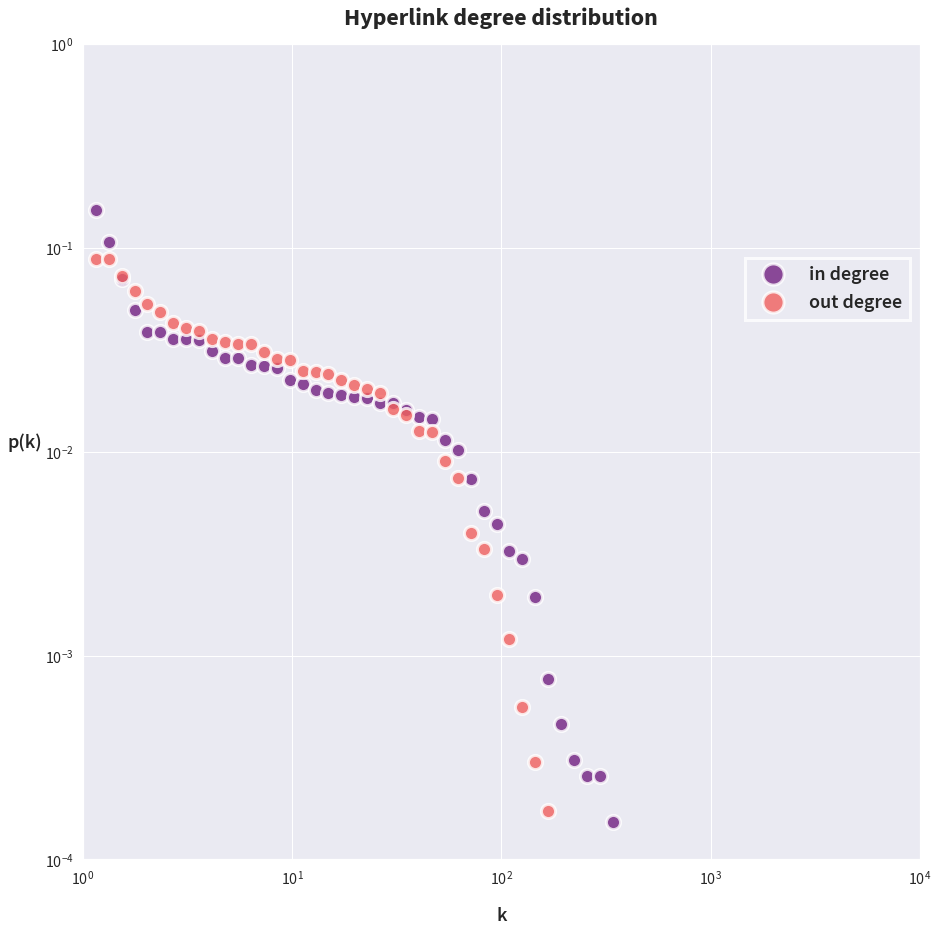

In [17]:
degree_dist(
    nodes.drop_duplicates("node")[["in_degree", "out_degree"]].values.T,
    "Hyperlink degree distribution",
    labels=["in degree", "out degree"],
)

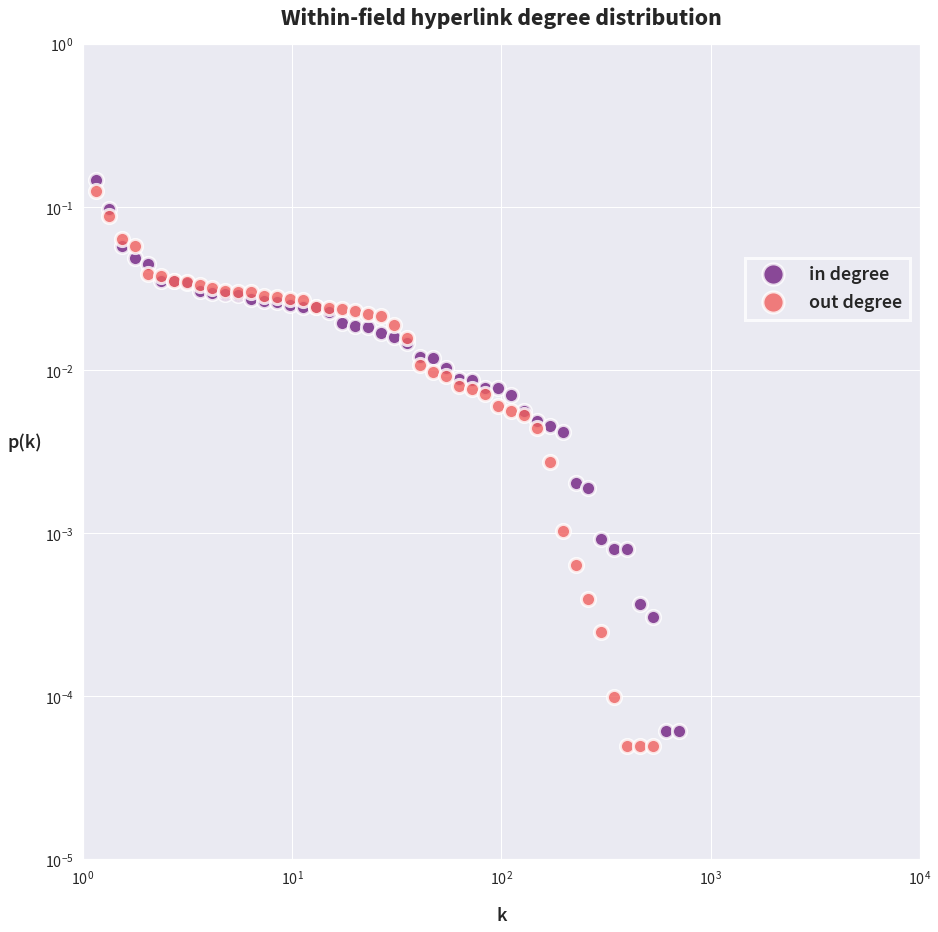

In [18]:
degree_dist(
    nodes.drop_duplicates("node")[
        ["within_field_in_degree", "within_field_out_degree"]
    ].values.T,
    "Within-field hyperlink degree distribution",
    labels=["in degree", "out degree"],
)

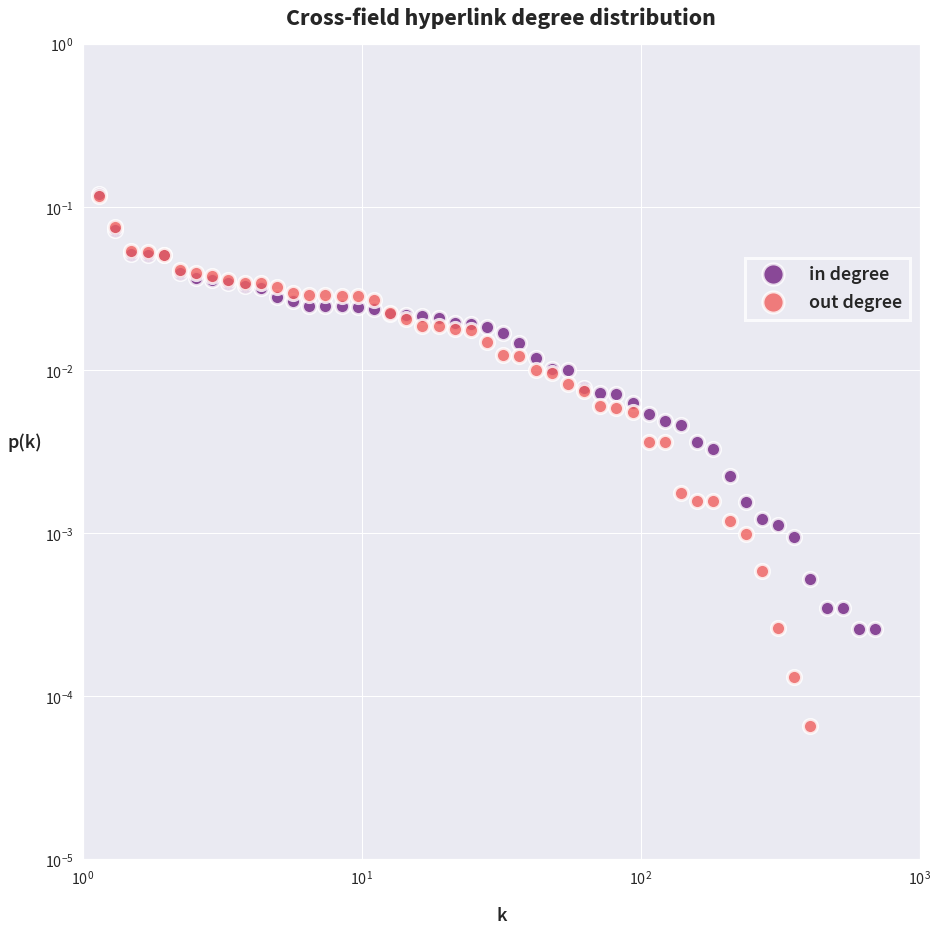

In [19]:
degree_dist(
    nodes.drop_duplicates("node")[
        ["cross_field_in_degree", "cross_field_out_degree"]
    ].values.T,
    "Cross-field hyperlink degree distribution",
    labels=["in degree", "out degree"],
)

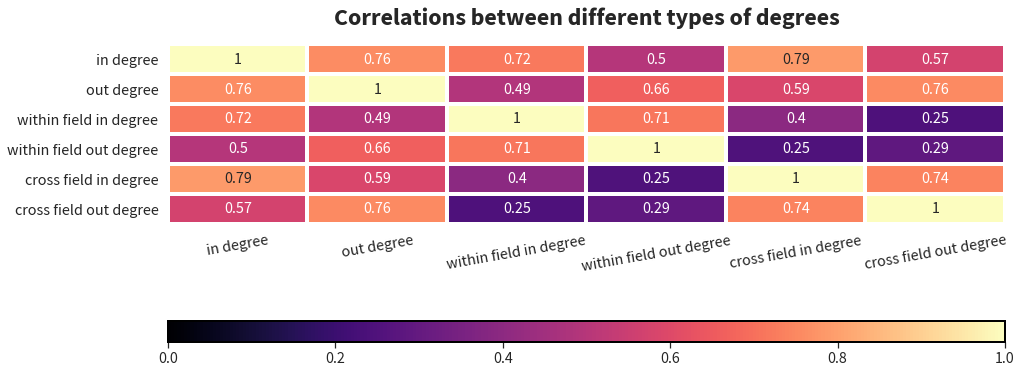

In [20]:
nodes[[c for c in nodes.columns if "degree" in c]].corr().abs().pipe(
    lambda df: corr_heatmap(
        df,
        "Correlations between different types of degrees",
        figsize=(15, 6),
        annot=df.round(2),
        xrotation=10,
        cbar_pad=0.3,
    )
)

-------------

### predict network attributes with field dummies <a id="ols">

[**back**](#contents)

In [63]:
field_dummies = (
    nodes.pivot_table(
        index="node", columns="field", values="in_degree", aggfunc="count"
    )
    .fillna(0)
    .sort_index()
)

In [59]:
field_dummies.to_parquet("output/field_dummies.parquet")

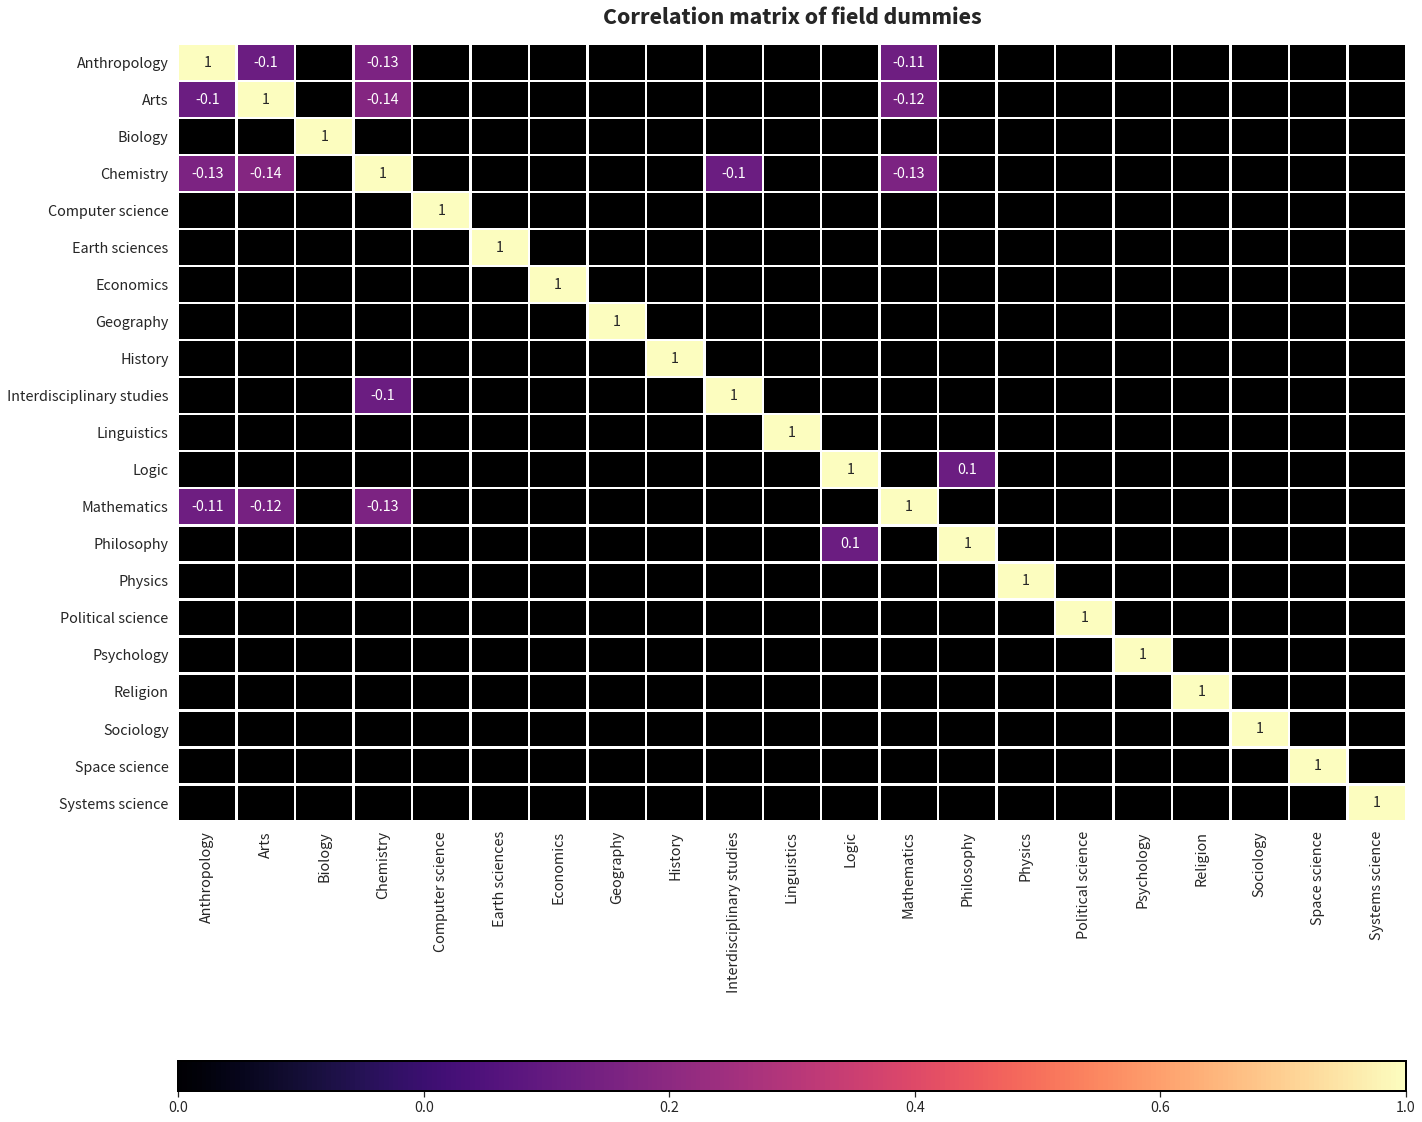

In [65]:
field_dummies.corr().pipe(
    lambda df: corr_heatmap(
        df.abs(),
        "Correlation matrix of field dummies",
        figsize=(22, 22),
        annot=df.round(2),
        mask=df.abs() < 0.1,
        enhance=True,
        cbar_pad=0.2,
    )
)

In [47]:
reg_df = (
    nodes[
        [
            "node",
            "in_degree",
            "out_degree",
            "in_neighbor_conn",
            "out_neighbor_conn",
            "clustering",
            "betweenness",
            "closeness_in",
            "closeness_out",
        ]
    ]
    .drop_duplicates()
    .set_index("node")
    .merge(
        nodes.groupby("node")[
            ["cross_field_in_degree", "cross_field_out_degree"]
        ].sum(),
        left_index=True,
        right_index=True,
    )
    .assign(
        p_cross_field_in=lambda df: df["cross_field_in_degree"] / df["in_degree"],
        p_cross_field_out=lambda df: df["cross_field_out_degree"] / df["out_degree"],
        log_in_degree=lambda df: np.log(df["in_degree"]),
        log_out_degree=lambda df: np.log(df["out_degree"]),
    )
    .fillna(0)
    .drop(
        ["in_degree", "out_degree", "cross_field_in_degree", "cross_field_out_degree"],
        axis=1,
    )
    .pipe(
        lambda df: pd.DataFrame(
            StandardScaler().fit_transform(df), columns=df.columns, index=df.index
        )
    )
    .sort_index()
)

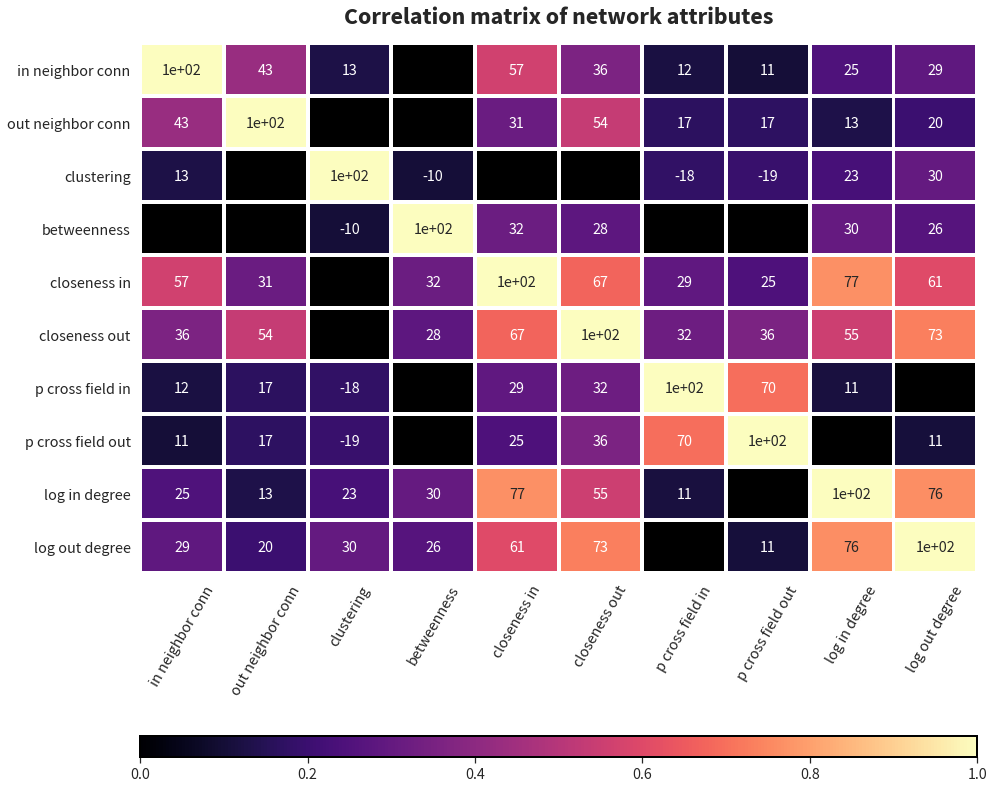

In [48]:
reg_df.corr().pipe(
    lambda df: corr_heatmap(
        df.abs(),
        "Correlation matrix of network attributes",
        annot=(df * 100).round(),
        mask=df.abs() < 0.1,
        cbar_pad=0.2,
        xrotation=60,
    )
)

In [14]:
test_sizes = np.linspace(0, 1, 20, endpoint=False)[1:]

In [15]:
field_dummies_norm = field_dummies.apply(lambda r: r / r.sum(), axis=1)

In [ ]:
all_gls_results = {
    s: {
        c: gls_model(field_dummies_norm, reg_df.loc[:, c], test_size=s)
        for c in reg_df.columns
    }
    for s in tqdm(test_sizes)
}

In [150]:
test_size = test_sizes[
    np.argmin(
        [np.mean([v["mse"] for v in r.values()]) for r in all_gls_results.values()]
    )
]

In [151]:
best_gls_result = all_gls_results[test_size]

In [152]:
gls_coeff_matrix = pd.concat(
    [v["coeffs"].rename(columns={"coeff": k}) for k, v in best_gls_result.items()],
    axis=1,
).pipe(lambda df: df.sort_values(by=df.columns.tolist(), ascending=False))

In [158]:
gls_coeff_matrix.to_parquet("output/gls_coeff_matrix.parquet")

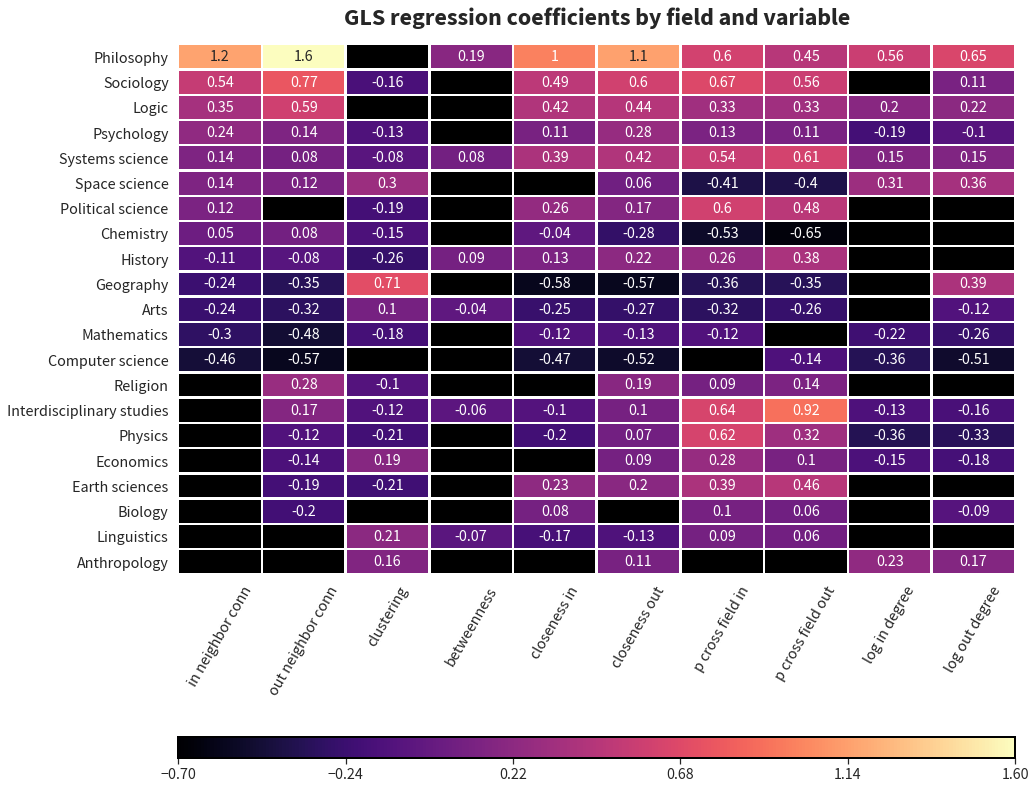

In [50]:
gls_coeff_matrix.pipe(
    lambda df: corr_heatmap(
        df,
        "GLS regression coefficients by field and variable",
        annot=df.round(2),
        vmin=df.round(1).min().min(),
        vmax=df.round(1).max().max(),
        mask=df.isna(),
        xrotation=60,
        cbar_nticks=6,
        cbar_pad=0.2,
    )
)

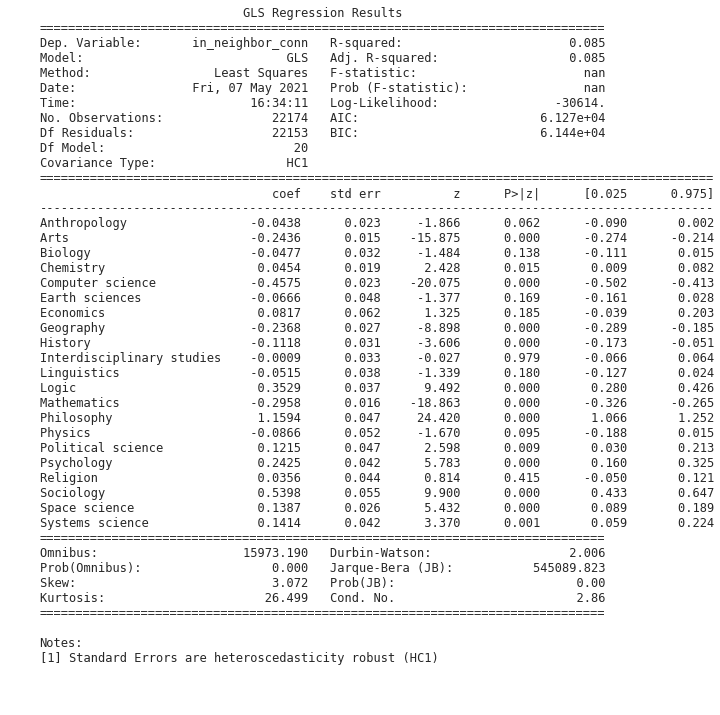

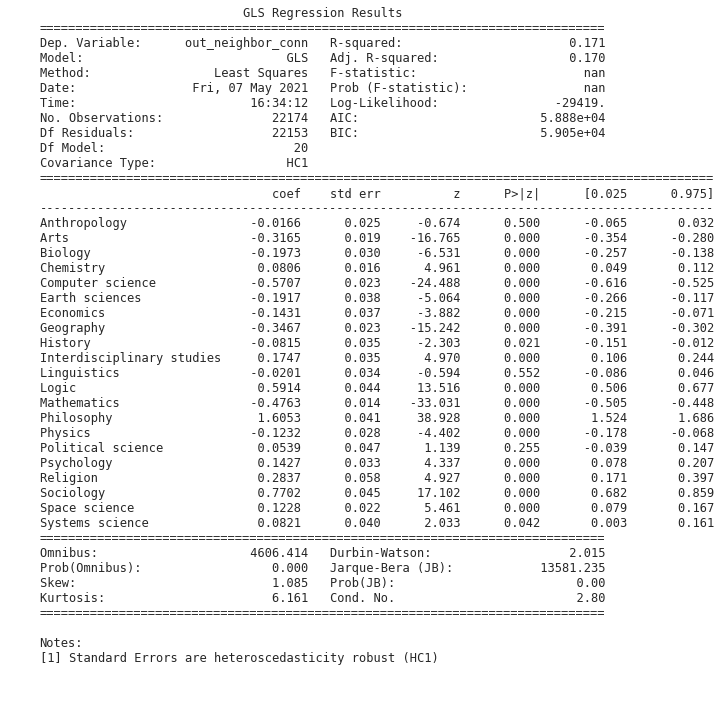

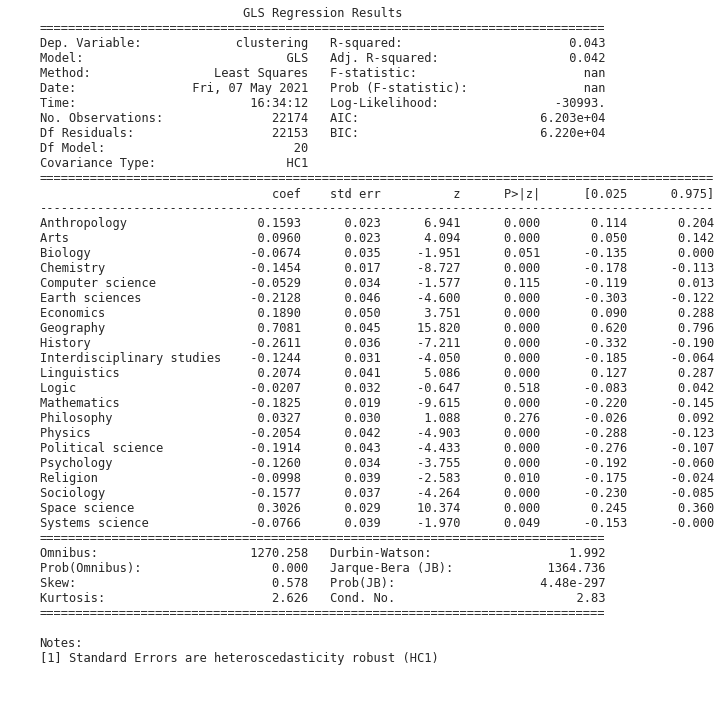

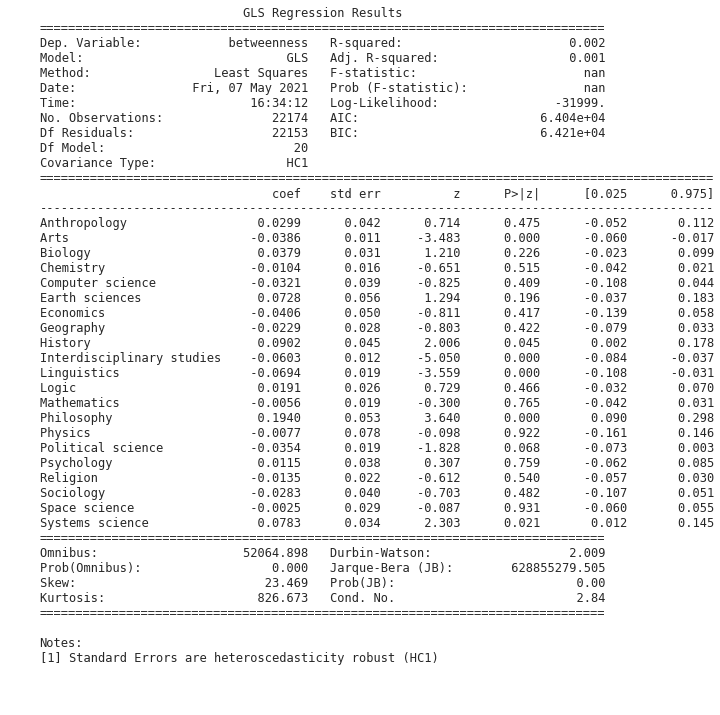

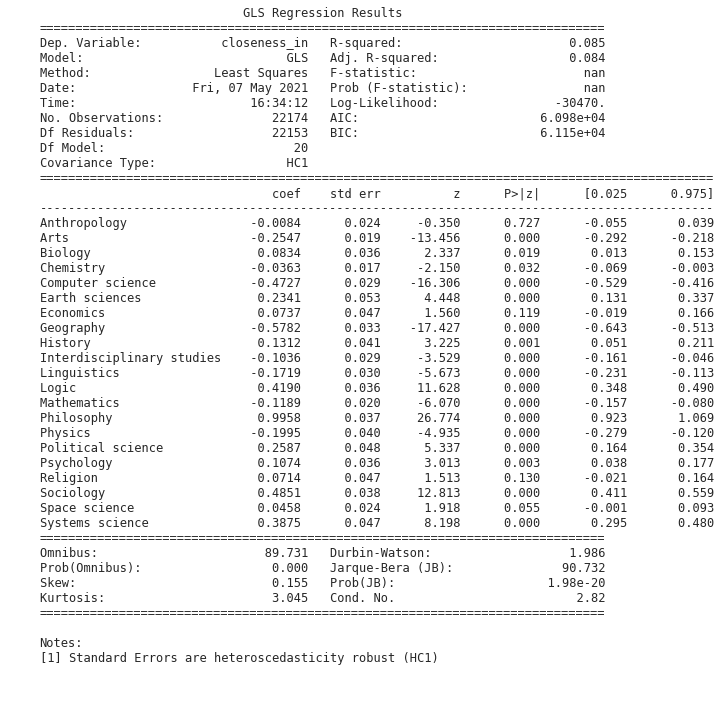

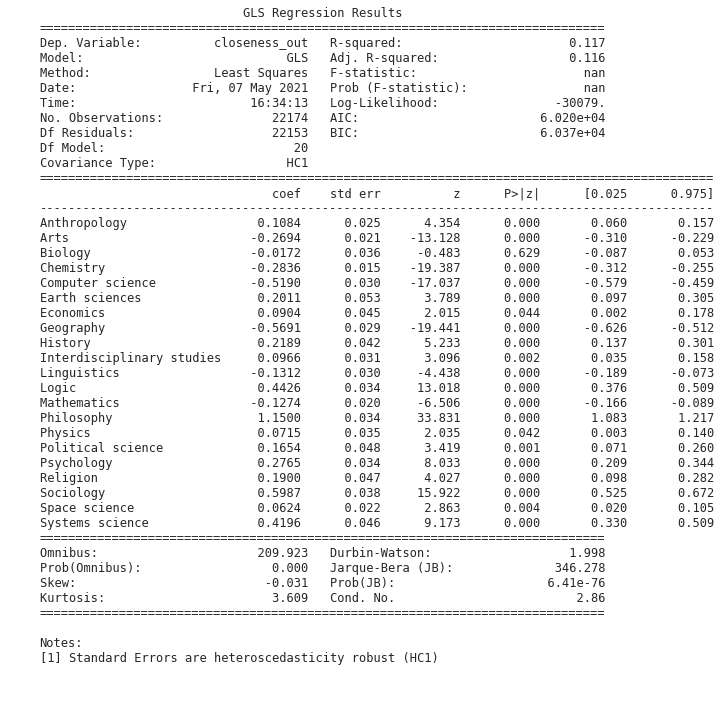

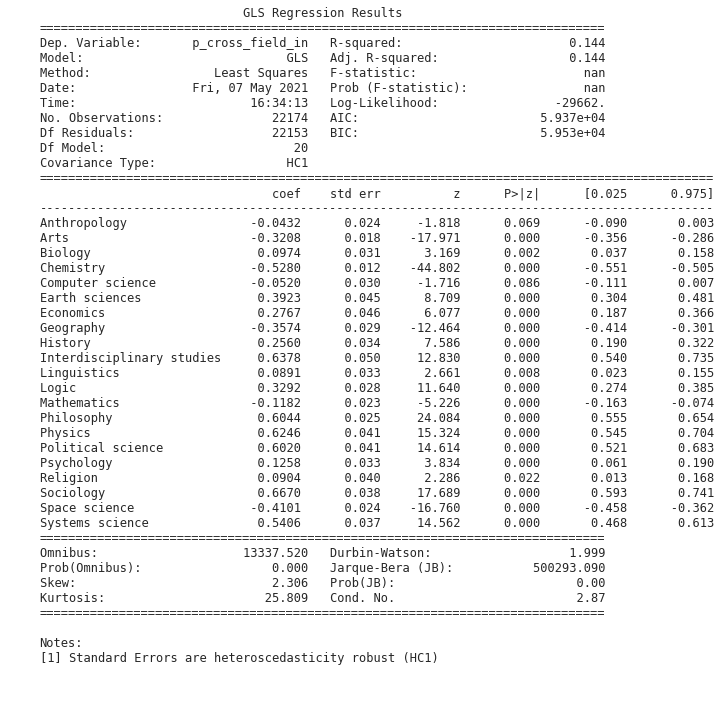

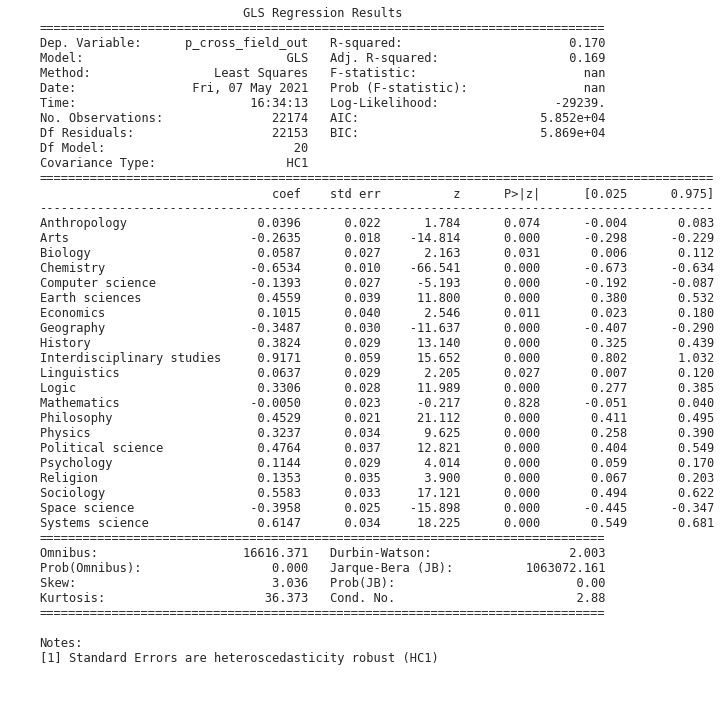

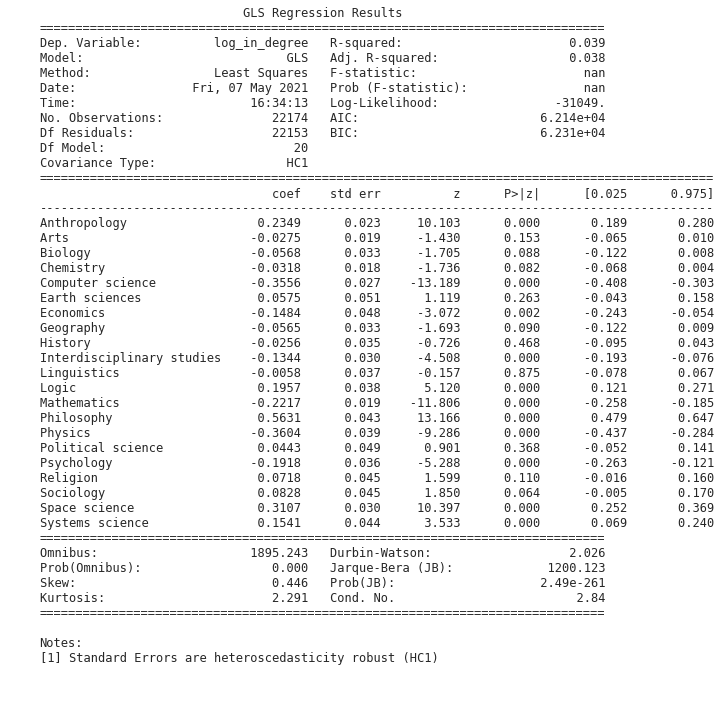

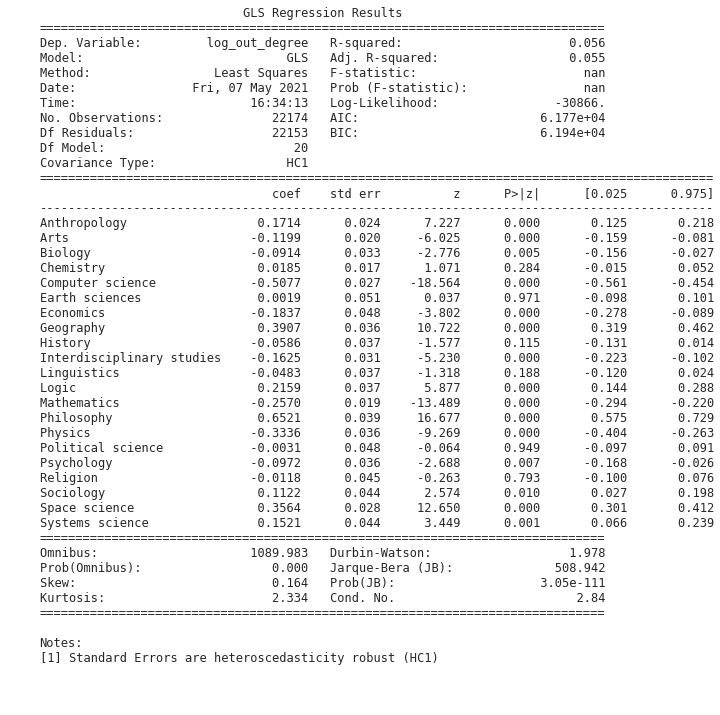

In [154]:
for k, v in best_gls_result.items():

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.text(
        0.01,
        0.05,
        str(v["model"].summary()),
        {"fontsize": 10},
        fontproperties="monospace",
    )
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(f"figs/gls_reg_summaries/{k}_model_summary.png")

-----------

### describe fields <a id="fields"></a>

[**back**](#contents)

In [34]:
field_link_matrix = (
    edges[["field_from", "field_to", "weight"]]
    .pivot_table(columns="field_from", index="field_to", values="weight", aggfunc="sum")
    .fillna(0)
)

In [35]:
field_link_matrix.to_parquet("output/depth_1_field_link_matrix.parquet")

In [39]:
fields = (
    (
        fields.assign(
            field=fields["field"].apply(
                lambda f: class_dict[f] if f in class_dict.keys() else f
            )
        )
        .drop_duplicates()
        .reset_index(drop=True)
    )
    .pipe(
        lambda df: df.merge(
            nodes.groupby("node")["field"]
            .nunique()
            .apply(lambda s: 1 / s)
            .reset_index()
            .rename(columns={"field": "n_nodes_weighted"})
            .merge(nodes[["node", "field"]], on="node", how="right")
            .groupby("field")["n_nodes_weighted"]
            .sum()
            .reset_index(),
            on="field",
            how="left",
        )
    )
    .pipe(
        lambda df: df.assign(
            rel_size=df["n_nodes_weighted"].pipe(lambda s: s / s.sum())
        )
        .fillna(0)
        .assign(
            ext_citations=df["field"].apply(
                lambda f: (
                    field_link_matrix.loc[f, :].sum() - field_link_matrix.loc[f, f]
                )
            )
        )
    )
    .pipe(
        lambda df: df.assign(
            rel_ext_use=lambda df: df["ext_citations"]
            / field_link_matrix.sum().sum()
            * (1 - df["rel_size"])
            / df["rel_size"],
            ext_cit_avg=lambda df: df["ext_citations"] / df["n_nodes_weighted"],
            imp_exp_ratio=lambda df: df["ext_citations"]
            / df["field"].apply(
                lambda f: (field_link_matrix[f].sum() - field_link_matrix.loc[f, f])
            ),
        )
        .merge(
            field_link_matrix.apply(lambda c: c / c.sum())
            .apply(lambda r: gini(r), axis=1)
            .reset_index()
            .rename(columns={"field_to": "field", 0: "gini"}),
            on="field",
        )
        .set_index("field")
        .sort_values(by=["broad_field", "rel_size"])
    )
    .pipe(
        lambda df: df.assign(
            color=magma_as_hex(df.shape[0]),
            color_b=df["broad_field"].apply(
                lambda s: {
                    f: magma_as_hex(df["broad_field"].nunique())[n]
                    for n, f in enumerate(df["broad_field"].sort_values().unique())
                }[s]
            ),
        )
    )
)

In [40]:
fields.head(5)

,broad_field,n_nodes_weighted,rel_size,ext_citations,rel_ext_use,ext_cit_avg,imp_exp_ratio,gini,color,color_b
field,,,,,,,,,,
Systems science,Formal sciences,670.950000,0.026873,14314.885000,0.790365,21.335249,0.975415,0.542169,#050417,#51127C
Logic,Formal sciences,856.483333,0.034304,18985.713056,0.814909,22.167055,0.959426,0.590753,#110C31,#51127C
Computer science,Formal sciences,1082.583333,0.043359,5214.434722,0.175410,4.816659,0.962129,0.844804,#1F114B,#51127C
Mathematics,Formal sciences,2535.116667,0.101536,18773.903889,0.253290,7.405538,0.970799,0.637910,#321067,#51127C
Economics,Humanities and social science,469.750000,0.018814,5988.444444,0.476166,12.748152,0.972014,0.766159,#470F78,#B73779


In [41]:
fields.to_parquet("output/fields.parquet")

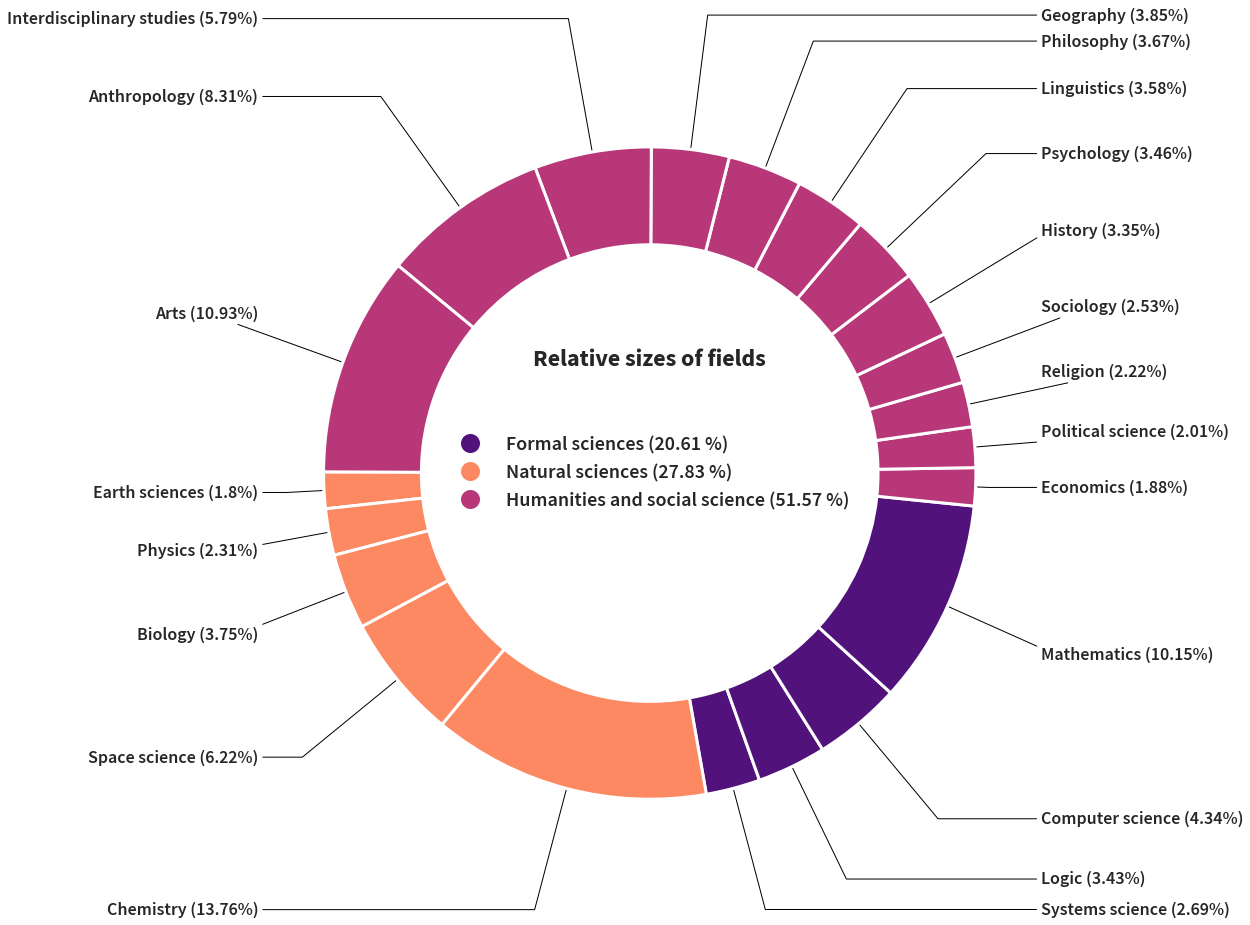

In [21]:
title = "Relative sizes of fields"

fig, ax = plt.subplots(figsize=(15, 15))

wedges, texts = ax.pie(
    fields["rel_size"].values,
    colors=fields["color_b"],
    wedgeprops={"width": 0.3, "linewidth": 3},
    startangle=-80,
)

for i, w in enumerate(wedges):

    ang = (w.theta2 - w.theta1) / 2.0 + w.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    ax.annotate(
        "{} ({}%)".format(
            fields.index[i],
            round(100 * fields["rel_size"].values[i], 2),
        ),
        xy=(x, y),
        xytext=(1.2 * np.sign(x), 1.4 * y),
        horizontalalignment="left" if np.sign(x) == 1 else "right",
        font_properties=font_props["label"],
        fontsize=18,
        arrowprops={
            "color": "black",
            "arrowstyle": "-",
            "connectionstyle": f"angle,angleA=0,angleB={ang}",
        },
    )

plt.title(title, fontproperties=font_props["title"], pad=-300)

fields.reset_index().groupby("broad_field")[["rel_size", "color_b"]].agg(
    {"rel_size": "sum", "color_b": "max"}
).sort_values(by="rel_size").pipe(
    lambda df: plt.legend(
        handles=[
            Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=20)
            for c in df["color_b"]
        ],
        labels=df.apply(
            lambda r: "{} ({} %)".format(r.name, round(r["rel_size"] * 100, 2)),
            axis=1,
        ).values.tolist(),
        loc="center",
        prop=font_props["label"],
        frameon=False,
    )
)

plt.savefig(
    "figs/{}.png".format("_".join(title.lower().split(" "))), bbox_inches="tight"
)

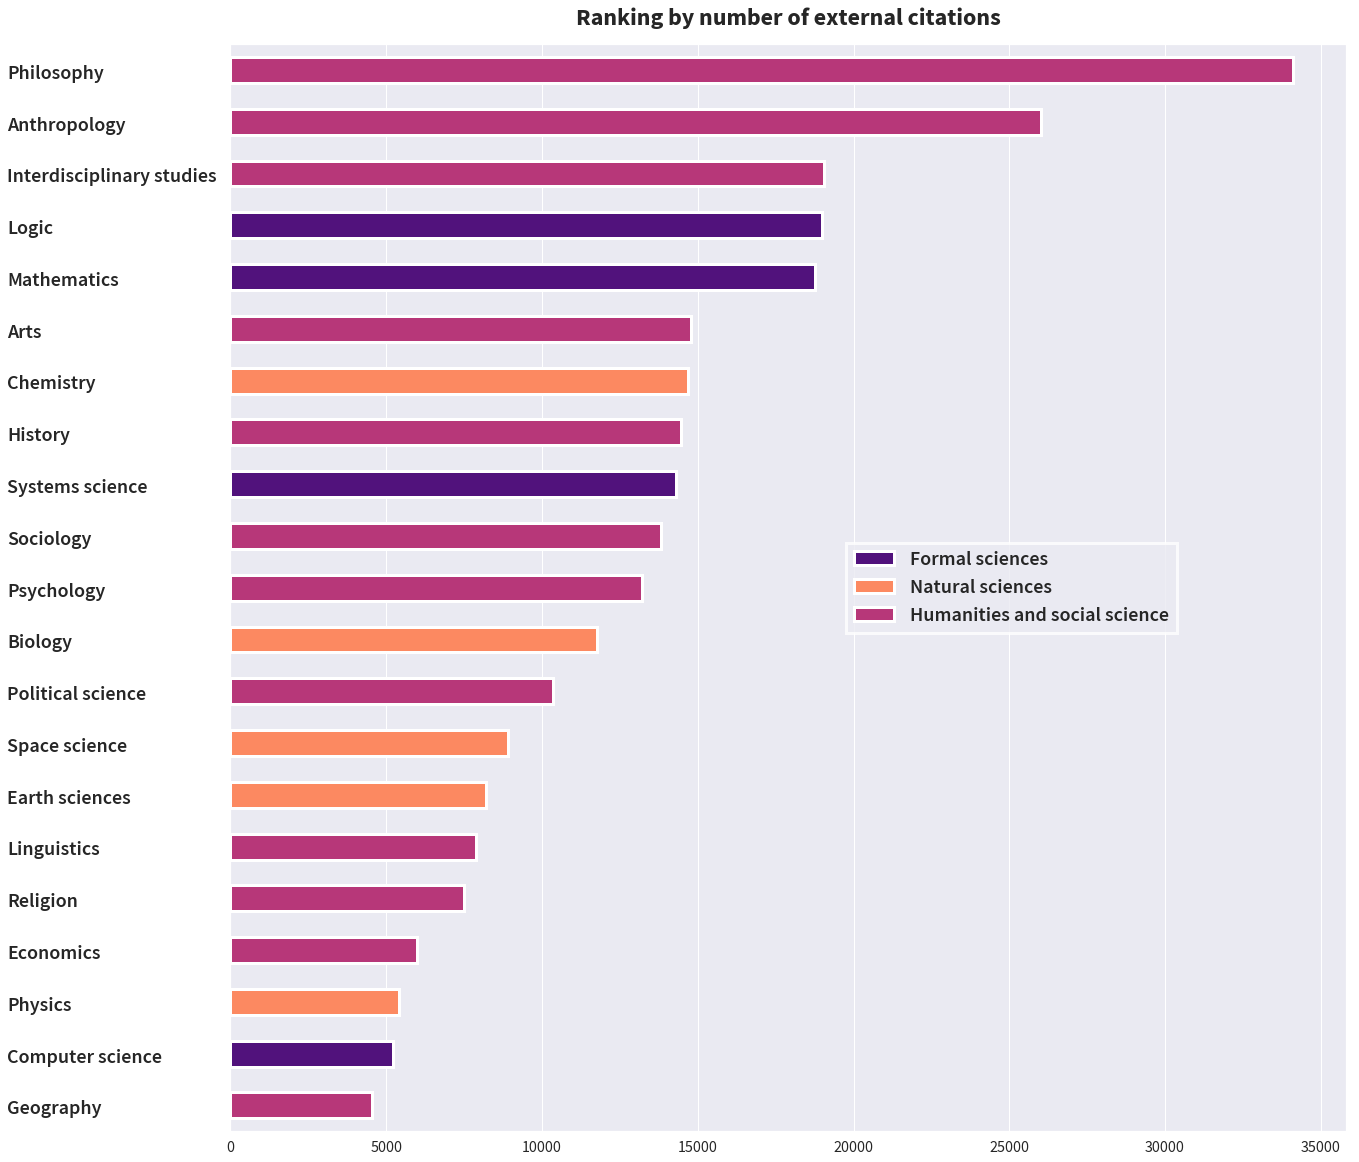

In [33]:
plot_ranking("ext_citations", legend=True)

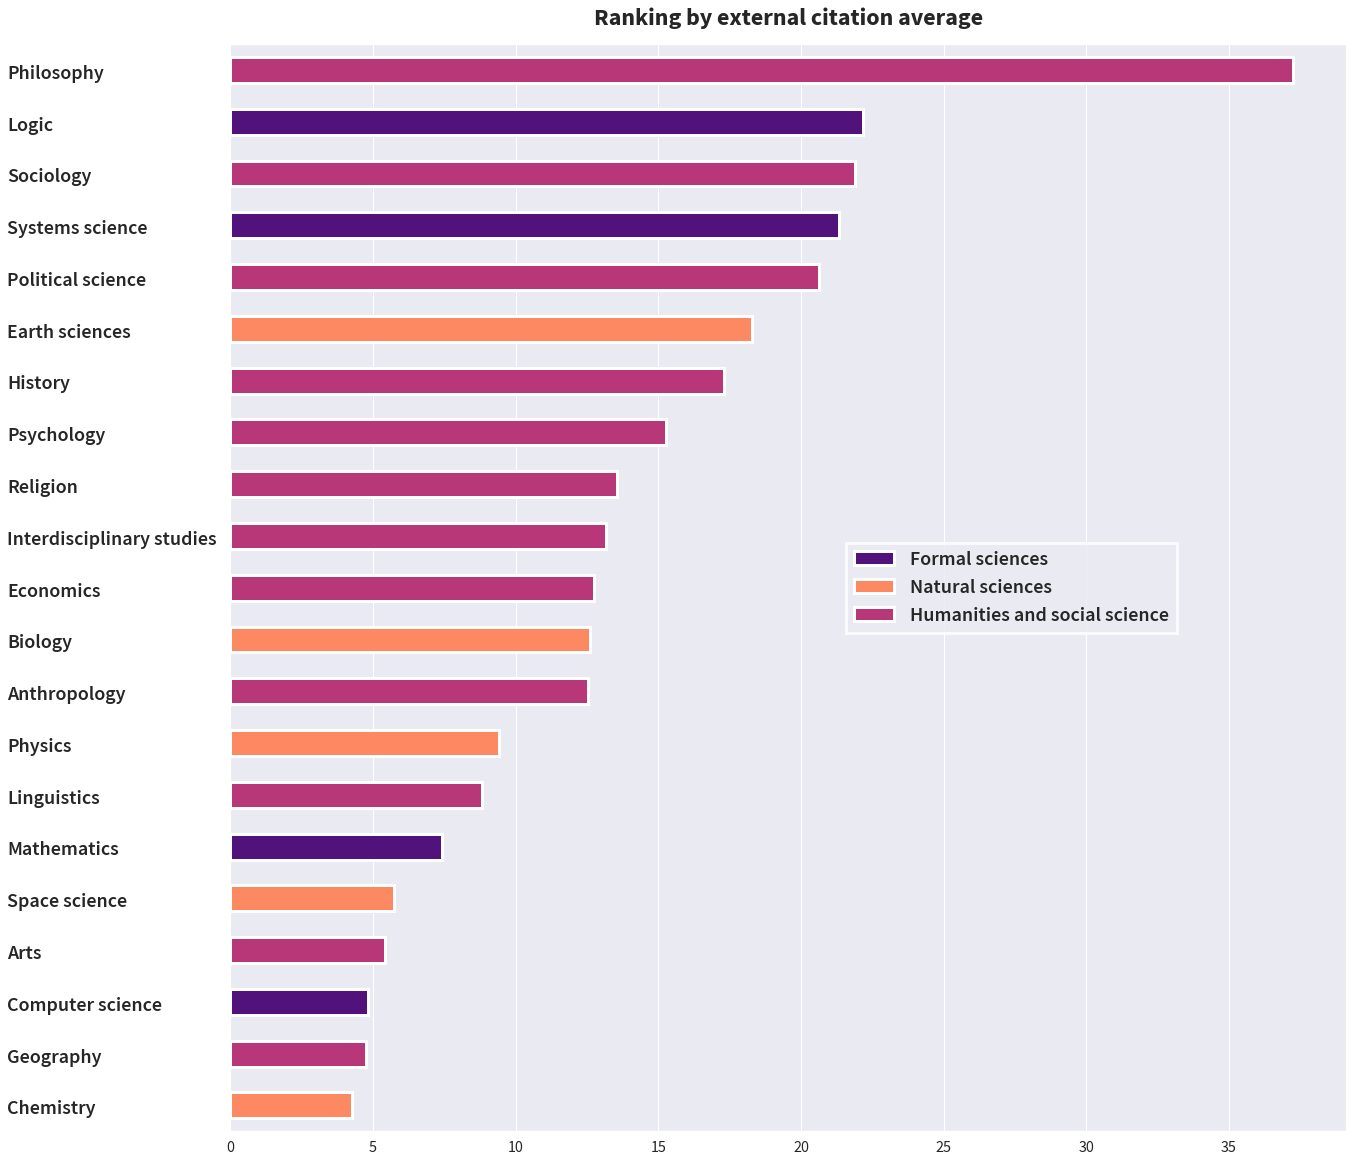

In [28]:
plot_ranking("ext_cit_avg", legend=True)

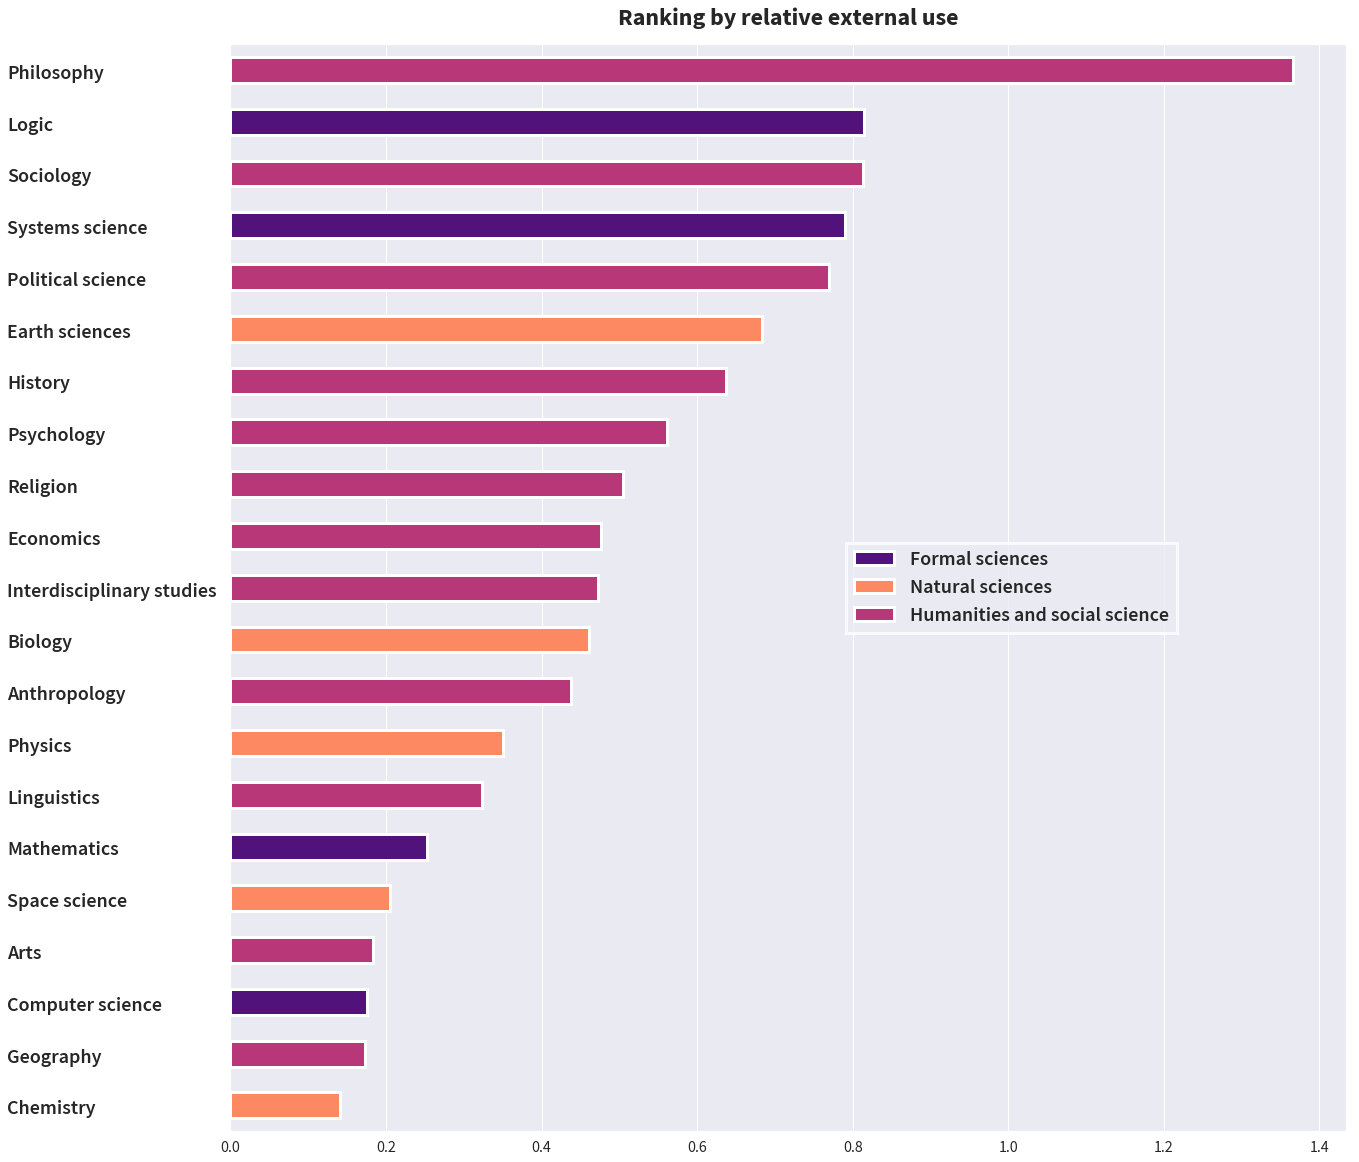

In [30]:
plot_ranking("rel_ext_use", legend=True)

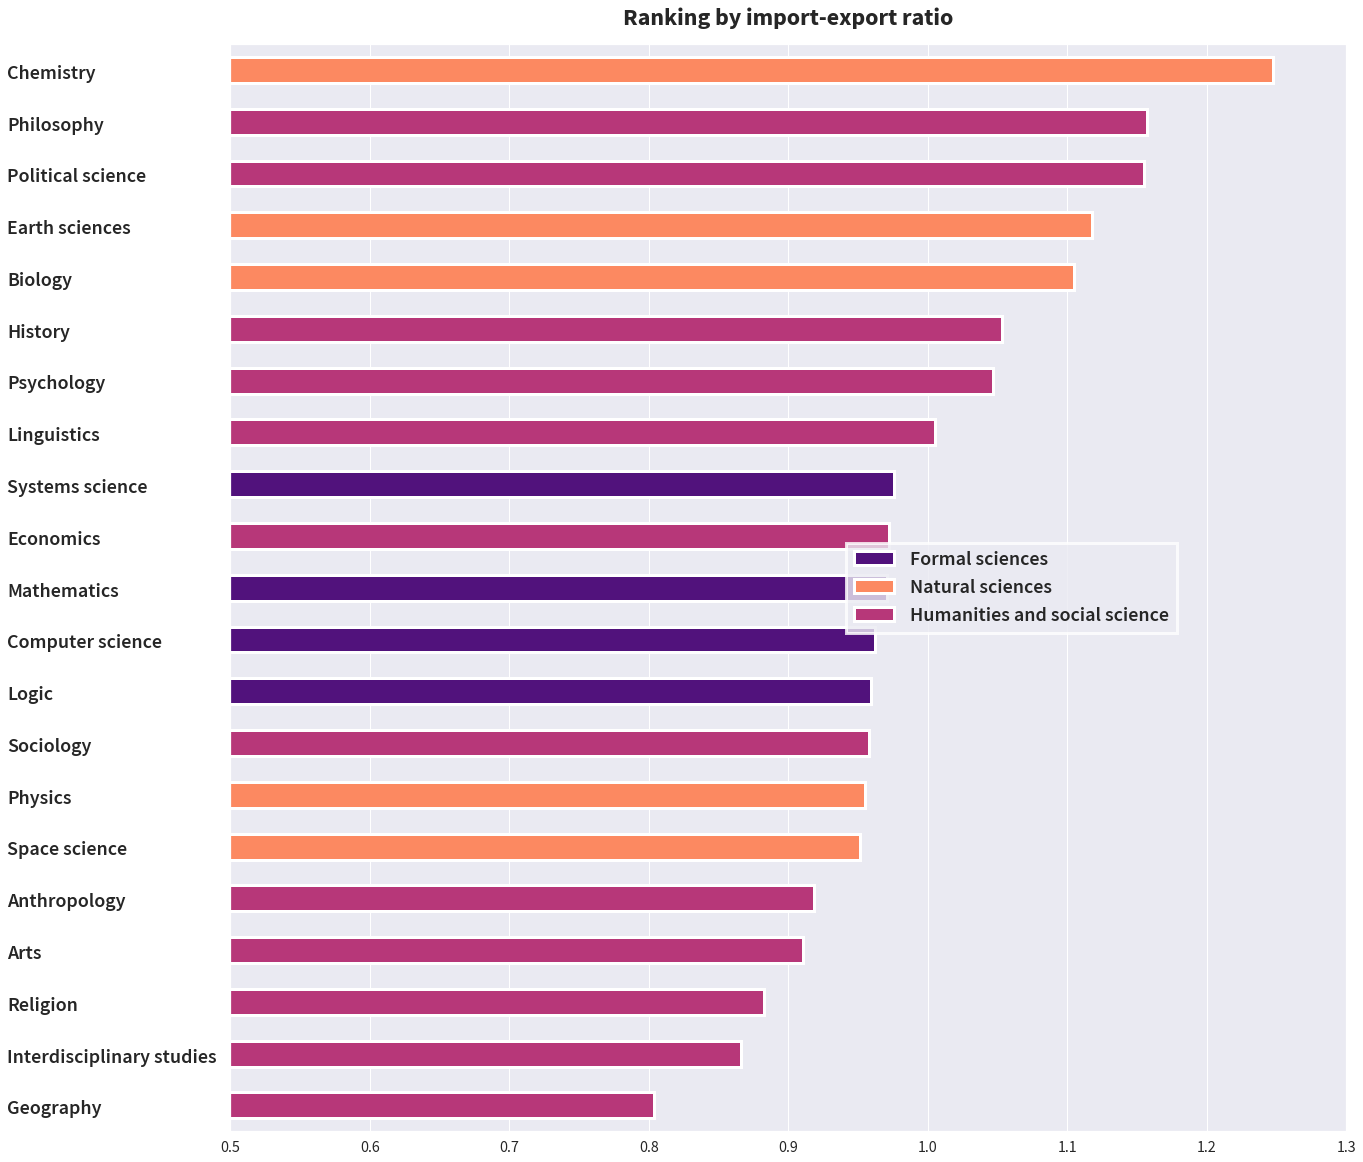

In [31]:
plot_ranking("imp_exp_ratio", legend=True)

In [35]:
def sort_adjacency_matrix(matrix):

    return matrix.apply(lambda c: c / c.sum()).pipe(
        lambda df: df.loc[
            df.apply(lambda r: 1 / (r > 0.05).sum(), axis=1)
            .reset_index()
            .rename(columns={0: "sign_count"})
            .sort_values(by=["sign_count", "field_to"])["field_to"]
            .values,
            :,
        ].pipe(lambda df: df.loc[:, df.index.tolist()])
    )
       

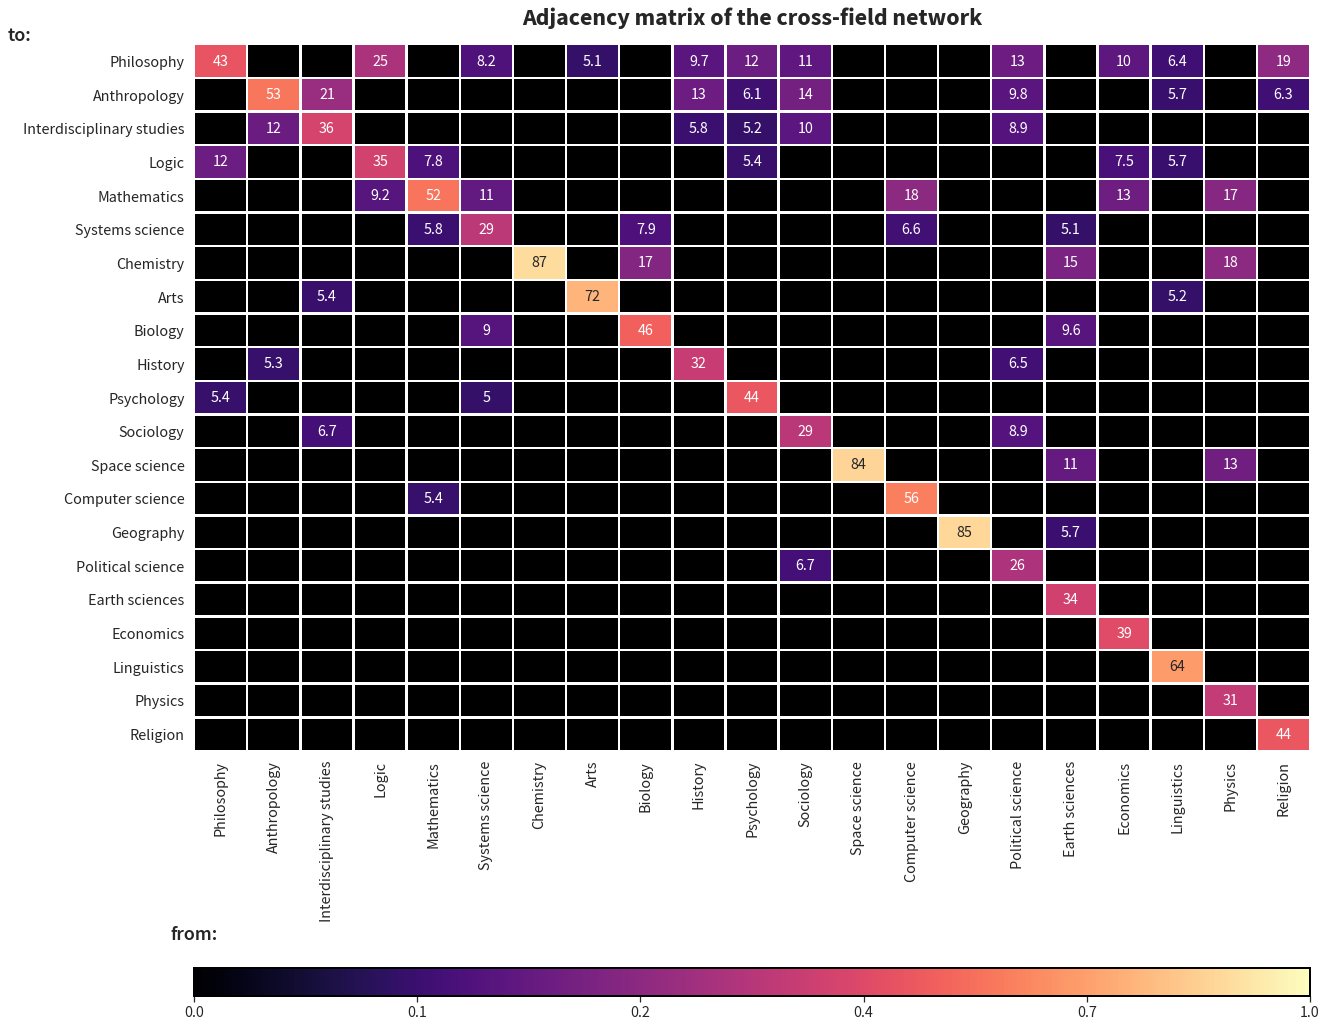

In [38]:
field_link_matrix.pipe(sort_adjacency_matrix).pipe(
    lambda df: corr_heatmap(
        df,
        "Adjacency matrix of the cross-field network",
        figsize=(20, 20),
        annot=(df * 100).round(2),
        vmin=0.05,
        mask=df < 0.05,
        enhance=True,
        xlabel="from:",
        ylabel="to:",
        cbar_pad=0.2,
    )
)

----------

### describe broad fields <a id="broad_desc">

[**back**](#contents)

In [40]:
broad_field_dict = {
    "hum_soc": {"keys": {"Humanities and social science"}},
    "nat_form": {"keys": {"Natural sciences", "Formal sciences"}},
}

In [ ]:
for k, v in broad_field_dict.items():

    g = build_graph(
        *articles.loc[lambda df: df["broad_field"].isin(v["keys"]), ["article"]]
        .drop_duplicates()
        .merge(
            edges[["from", "to"]].drop_duplicates(), left_on="article", right_on="from"
        )
        .loc[lambda df: df["to"].isin(df["article"].unique())]
        .pipe(lambda df: (df["article"].unique(), df[["from", "to"]].values)),
        False,
        True,
        print_info=False
    )

    broad_field_dict[k]["g"] = g.subgraph(
        max(nx.strongly_connected_components(g), key=len)
    )

    broad_field_dict[k]["nodes"] = (
        articles.loc[
            lambda df: (df["broad_field"].isin(v["keys"]))
            & df["article"].isin(set(broad_field_dict[k]["g"].nodes()))
        ]
        .drop("broad_field", axis=1)
        .reset_index(drop=True)
        .rename(columns={"article": "node"})
    )

    broad_field_dict[k]["edges"] = (
        articles.loc[lambda df: (df["broad_field"].isin(v["keys"]))]
        .drop("broad_field", axis=1)
        .pipe(
            lambda df: df.rename(columns={"field": "field_from", "article": "from"})
            .merge(
                pd.DataFrame(
                    list(broad_field_dict[k]["g"].edges()), columns=["from", "to"]
                ),
                on="from",
            )
            .merge(df.rename(columns={"field": "field_to", "article": "to"}), on="to")
            .pipe(
                lambda df: df.merge(
                    df.groupby(["from", "to"])["field_from"]
                    .count()
                    .pipe(lambda s: 1 / s)
                    .reset_index()
                    .rename(columns={"field_from": "weight"}),
                    on=["from", "to"],
                    how="left",
                )
            )
            .sort_values(by=["from", "to"])
            .reset_index(drop=True)
        )
    )

    broad_field_dict[k]["field_link_matrix"] = (
        broad_field_dict[k]["edges"][["field_from", "field_to", "weight"]]
        .pivot_table(
            columns="field_from", index="field_to", values="weight", aggfunc="sum"
        )
        .fillna(0)
    ).apply(lambda c: c / c.sum())

    G_broad_field = build_graph(
        fields.loc[lambda df: df["broad_field"].isin(v["keys"])].index.tolist(),
        (broad_field_dict[k]["field_link_matrix"].unstack().reset_index()).values,
        True,
        True,
        print_info=False,
    )

    G_broad_field_backbone = backbone_extraction(G_broad_field, 0.1, print_info=False)

    broad_field_dict[k]["backbone_adj"] = (
        pd.DataFrame(
            [
                {**{"field_from": edge[0], "field_to": edge[1]}, **edge[2]}
                for edge in G_broad_field_backbone.edges(data=True)
            ]
        )
        .pivot_table(
            columns="field_from", index="field_to", values="weight", aggfunc="sum"
        )
        .fillna(0)
    )

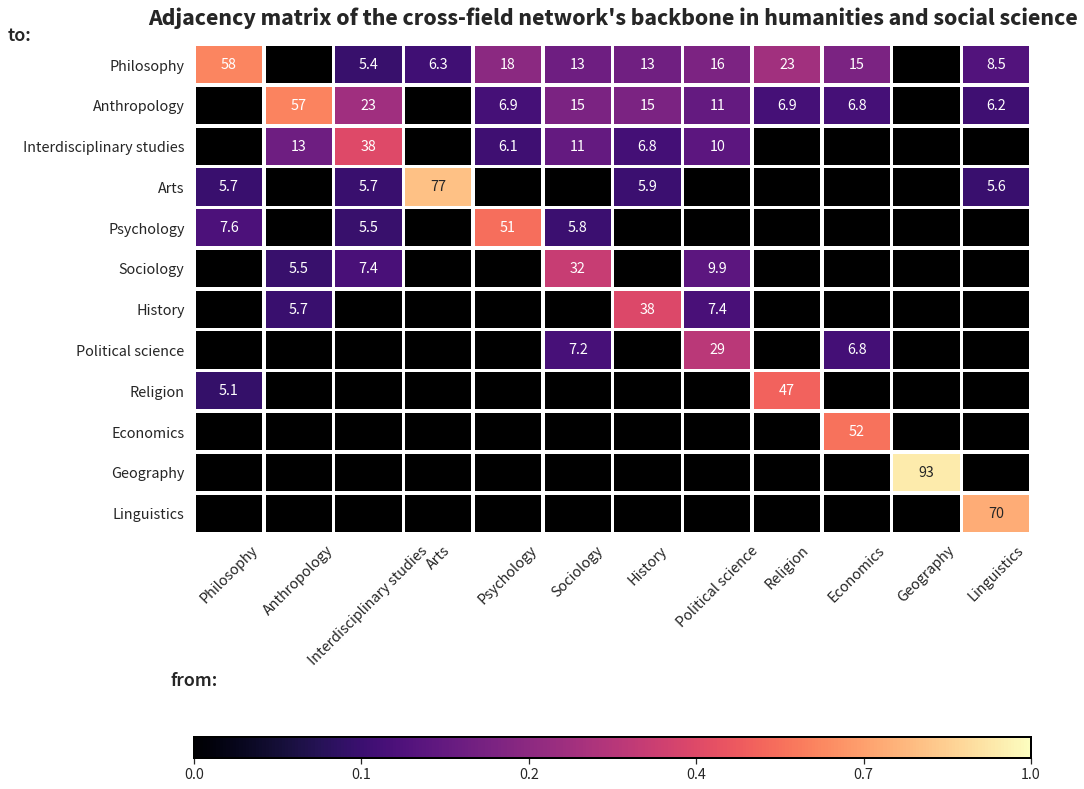

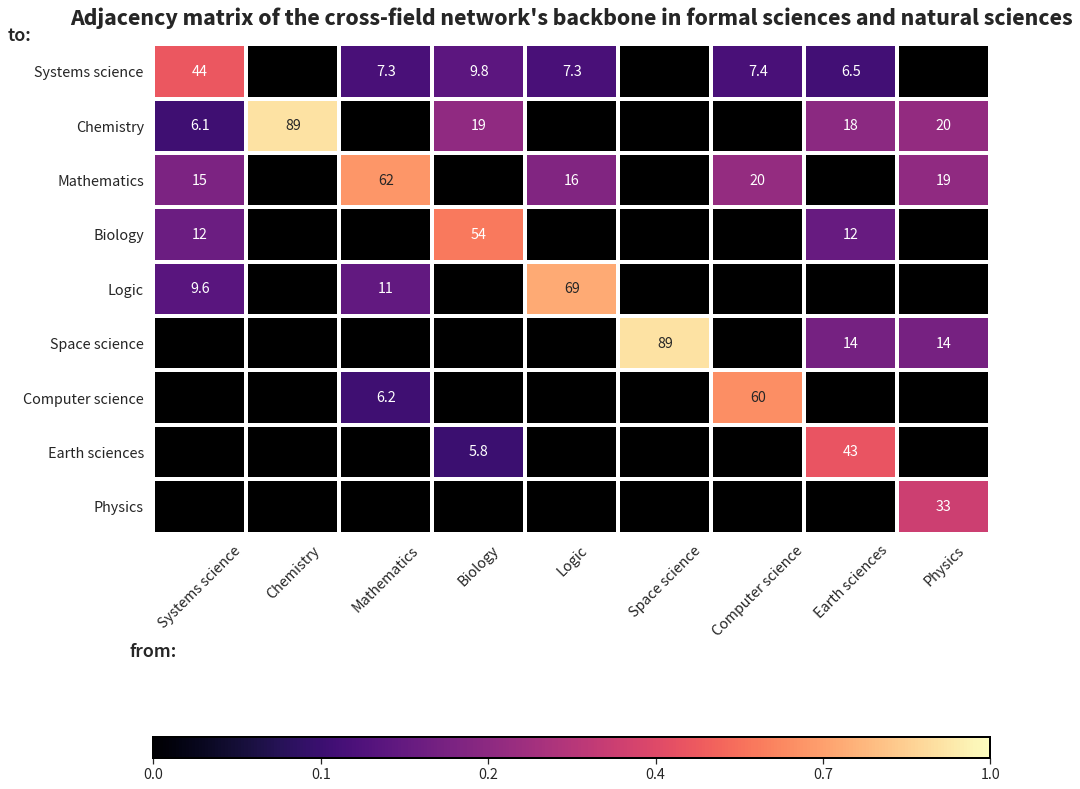

In [46]:
for k, v in broad_field_dict.items():

    title = "Adjacency matrix of the cross-field network's backbone in {}".format(
        " and ".join([f.lower() for f in v["keys"]])
    )

    v["field_link_matrix"].pipe(sort_adjacency_matrix).pipe(
        lambda df: corr_heatmap(
            df,
            title,
            annot=(df * 100).round(2),
            vmin=0.05,
            mask=df < 0.05,
            enhance=True,
            xlabel="from:",
            ylabel="to:",
            xrotation=45,
            cbar_pad=0.25,
        )
    )

    plt.savefig(
        "figs/{}".format("_".join(title.lower().split(" "))),
        bbox_inches="tight",
    )

----------

### depth *n* cross-field networks <a id="depth">

#### [back](#contents)

In [9]:
index_df = (
    pd.DataFrame(
        [[i, n] for i, n in enumerate(L_link.nodes())], columns=["index", "node"]
    )
    .merge(nodes[["node", "field"]], on="node")
    .merge(
        fields.assign(field_index=range(fields.shape[0]))[
            ["field_index"]
        ].reset_index(),
        on="field",
    )
    .assign(
        fieldcount=lambda df: df.groupby("index")["field_index"]
        .transform("nunique")
        .values
    )
)

In [ ]:
secondary_field_link_matrix = depth_n_field_edges(L_link, 2, index_df)
tertiary_field_link_matrix = depth_n_field_edges(L_link, 3, index_df)

-------